In [1]:
import keras

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
length = 10
input_length = length
output_length = length

In [3]:
x_train = np.round(np.random.uniform(0,1,[length])).reshape([1,length,1])
x_train

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]]])

In [4]:
def parity(x):
    temp = np.zeros(x.shape)
    mem = False
# Iterate over the sequence
    for i in range(x.shape[0]):
        if x[i,0] > 0.5:
            current = True
        else:
            current= False
        mem = np.logical_xor(mem,current)
        if mem:
            temp[i,0] = 1.0
        else:
            temp[i,0] = 0.0
    return (temp.reshape(1,temp.shape[0],temp.shape[1])) # Tensor!

In [5]:
y_train = parity(x_train[0,:,:])
y_train

array([[[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]]])

In [6]:
 Y = np.expand_dims(np.vstack([np.array([0,0,1,0]),
np.hstack([keras.utils.to_categorical(y_train[0,:,0]),np.zeros([
output_length,2])]),
np.array([0,0,0,1])]),axis=0)
Y
X = np.expand_dims(keras.utils.to_categorical(x_train[0,:,0]),axis=0)
X

array([[[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]]], dtype=float32)

In [7]:
X.shape



(1, 10, 2)

In [8]:
Y.shape

(1, 12, 4)

In [9]:
# 12 time steps total (10 + start + stop)
# Divide into two groups of 11
# First from 0 ... 10
preY = Y[:,0:output_length+1,:]
# Second from 1 ... 11
postY = Y[:,1:output_length+2,:]



In [10]:
preY.shape

(1, 11, 4)

In [11]:
postY.shape

(1, 11, 4)

In [12]:
# Size of the gestalt, context representations...
hidden_size = 20
## Encoder Construction
# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(),
metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 20), (None,  1840        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 20), ( 2000        input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [15]:
batch_size = 1 
epochs = 200
history = model.fit([X,preY], postY, batch_size=batch_size,epochs=epochs,verbose=0)
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

1/1 [==============================] - 0s 3ms/step
Accuracy: 100.0 %


Text(0.5, 0, 'epoch')

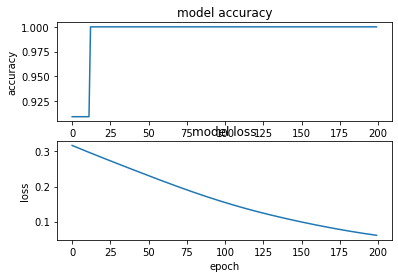

In [16]:
plt.figure(1)
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [18]:
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
[decoder_input] + decoder_states_input,
[decoder_output] + decoder_states)


In [19]:
context = encoder_model.predict(X)

token = np.zeros([1,1,Y.shape[2]])
token[0,0,2]=1
token

array([[[0., 0., 1., 0.]]])

In [20]:
result = np.zeros(postY.shape)
for x in range(output_length+1):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
result

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

In [21]:
postY

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

In [23]:
# New length
length = 10
input_length = length
output_length = length
# Set number of patterns here
n_seq = 100
# Generate the Xs
x_train = np.concatenate([np.round(np.random.uniform(0,1,[length])).reshape([1,length,1]) for x in range(n_seq)])
y_train = np.concatenate([parity(x_train[x,:,:]) for x in range(n_seq)])
# Reformat - dictionary approach
X = np.concatenate([np.expand_dims(keras.utils.to_categorical(x_train[x,:,:]),axis=0) for x in range(n_seq)])
Y = np.concatenate([np.expand_dims(np.vstack([np.array([0,0,1,0]),
np.hstack([keras.utils.to_categorical(y_train[x,:,:]),np.zeros([output_length,2])]),
np.array([0,0,0,1])]),axis=0) for x in range(n_seq)])
preY = Y[:,0:length+1,:]
postY = Y[:,1:length+2,:]

In [24]:
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(100, 10, 2)
(100, 12, 4)
(100, 11, 4)
(100, 11, 4)


In [26]:
 # Same as before...
# Size of the gestalt, context representations...
hidden_size = 20
## Encoder Construction
# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state
=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adam(),
metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 20), (None,  1840        input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 20), ( 2000        input_6[0][0]                    
                                                                 lstm_3[0][1]               

In [27]:
batch_size = 20 # many patterns...
epochs = 1500
history = model.fit([X,preY], postY,
batch_size=batch_size,
epochs=epochs,
verbose=0, # Turning off output due to many epochs...
validation_split = 0.2) # Remember, teacher forced, but a little informative...
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

100/100 [==============================] - 0s 229us/step
Accuracy: 91.4545476436615 %


Text(0.5, 0, 'epoch')

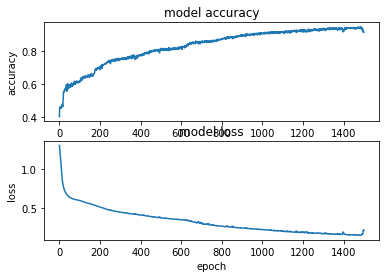

In [28]:
plt.figure(1)
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [29]:
## Testing - Again, separate the encoder-decoder for teacher forcing...
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
[decoder_input] + decoder_states_input,
[decoder_output] + decoder_states)


In [31]:
# Testing time...
error = 0
for p in range(n_seq):
# Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[p:p+1,:,:])
# Prep a starting token [[[0,0,1,0]]]..
    token = np.zeros([1,1,Y.shape[2]])
    token[0,0,2] = 1
    token
# Complete 11 cycles with the decoder
    result = np.zeros(postY.shape)
    for x in range(output_length+1):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    error += np.sum(np.abs(result-postY[p:p+1,:,:]))/2.0

In [32]:
print("Overall accuracy: %f%%"%(100.0 - (error / (n_seq*output_length))))

Overall accuracy: 86.400000%


In [33]:
!head /home/sandbox/gutenberg_example/PandP_Jane_Austen.txt


'head' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# Preprocessing - grab lines from the file
with open('/home/sandbox/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
min_length = max([len(i) for i in text])
# Visual Confirmation that we have loaded the text in...
text[0:8]


FileNotFoundError: [Errno 2] No such file or directory: '/home/sandbox/gutenberg_example/PandP_Jane_Austen.txt'